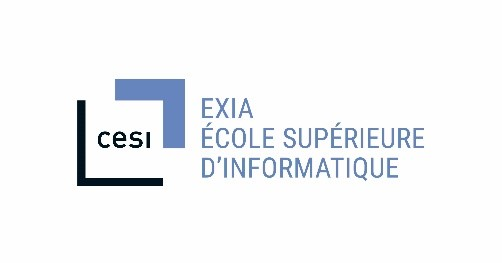


# **Livrable 01 - Classification (PHASE 1)**

#### **Membre du groupe**

*   Zinedine Ait Rabah Djaafer
*   Soltane Benghezal
*   Fares Mounir Merzouk
*   Ghada Messaour
####  **Chef de groupe** 
*   Abdelhamid Larachi

#### **Pilote de Formation : Mr. Fayçal Khetar**
#### **Pilote de l'option : Mr. Hani Afrit**
---





 




# **Description du livrable**

Le livrable sera sous la forme notebook Jupyter et devra, pour être validé, intégrer :

    Le code TensorFlow ainsi qu'un schéma de l'architecture du réseau de neurones. Toutes les parties doivent être détaillées dans le notebook : les paramètres du réseau, la fonction de perte ainsi que l'algorithme d'optimisation utilisé pour l’entraînement.

    Un graphique contenant l'évolution de l'erreur d’entraînement ainsi que de l'erreur de test et l'évolution de l'accuracy pour ces deux datasets.

    L'analyse de ces résultats, notamment le compromis entre biais et variance (ou sur-apprentissage et sous-apprentissage).

    Une description des méthodes potentiellement utilisables pour améliorer les compromis biais/variance : technique de régularisation, drop out, early-stopping, ...

Plusieurs datasets sont à votre disposition. On a :

    - Des peintures
    - Des Schéma et graphes
    - Des portraits dessinés en noir et blanc
    - Des images de textes scannés
    - Des photos

Les images ne sont pas étiquetées, mais ce n'est pas un problème puisqu'elles sont réparties dans des archives différentes.

Le but ultime est d'être capable de distinguer les photos parmi toutes ces images. Il est tout de même conseillé de commencer par les images les plus faciles à distinguer des photos, puis aller vers les dataset les plus difficiles à classifier (notamment, il y a dans le dataset peinture un certain nombre d'œuvres au rendu assez réaliste, qui devraient nous poser problème).

**Importer TensorFlow et d'autres bibliothèques**

---



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import random
from imageio import imread
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Télécharger et explorer l'ensemble des données**

---

Dans ce fichier, nous allons utiliser un jeu de données de divers images.
Le jeu de données contient cinq sous-répertoires, un par classe :

```
Images/
  Painting/
  Photo/
  Schematics/
  Sketch/
  Text/
```

In [2]:
import pathlib
data_dir = r'C:\Users\FoxHound\AI\dataset_b'
data_dir = pathlib.Path(data_dir)

Après le téléchargement, nous devrons disposer d'une copie de l'ensemble de données. Il y a 41 406 images au total :

In [3]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

41405


Voici quelques photos :

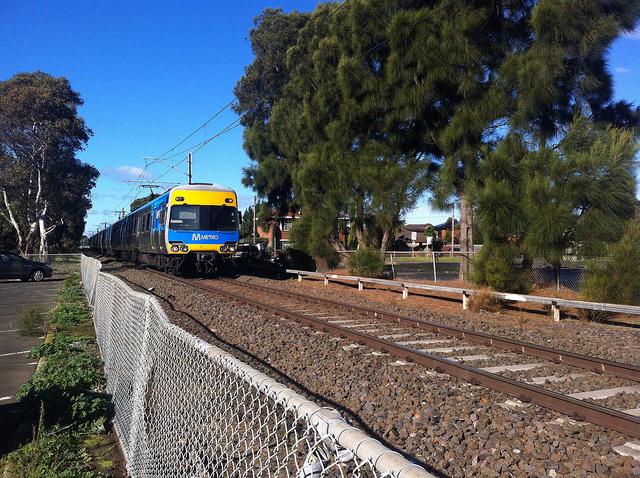

In [5]:
photos = list(data_dir.glob('Photo/*'))
PIL.Image.open(str(photos[0]))

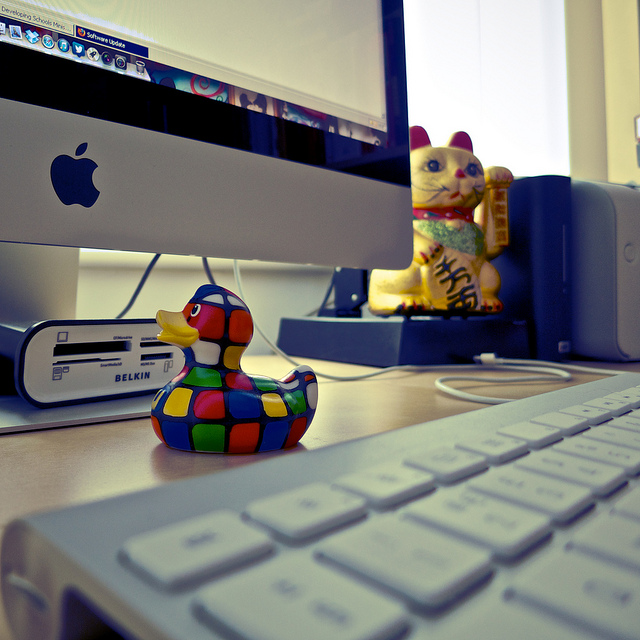

In [7]:
PIL.Image.open(str(photos[4]))

Autres :

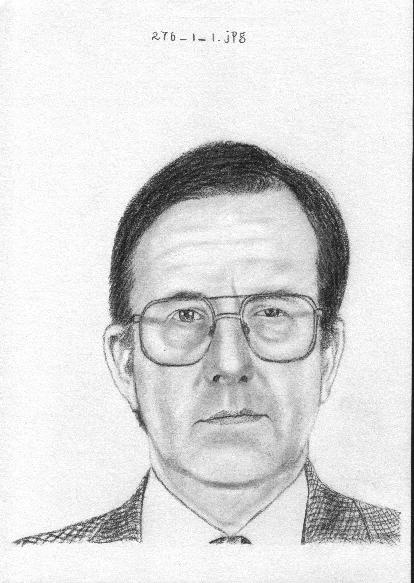

In [6]:
others = list(data_dir.glob('Others/*'))
PIL.Image.open(str(others[711]))

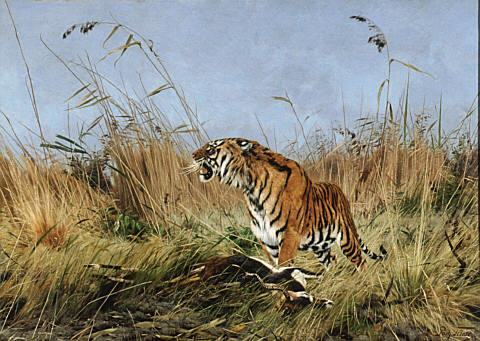

In [7]:
PIL.Image.open(str(others[4000]))

**Chargement des données à l'aide d'un utilitaire Keras**
---


Chargeons ces images depuis le disque en utilisant l'utile utilitaire `tf.keras.utils.image_dataset_from_directory`. Cela nous permettra de passer d'un répertoire d'images sur le disque à un `tf.data.Dataset` en seulement quelques lignes de code.

## **Créer un ensemble de données**

---



Définir quelques paramètres pour le loader :

In [8]:
batch_size = 32
img_height = 180
img_width = 180

C'est une bonne pratique d'utiliser un fractionnement de validation lors du développement de votre modèle. Réservons 80 % des images pour l'entraînement et 20 % pour la validation.

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    # using only 2 classes [photos / Others]
    label_mode="binary",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 41405 files belonging to 2 classes.
Using 33124 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode="binary",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 41405 files belonging to 2 classes.
Using 8281 files for validation.


Dans le cas de la recherche des noms de classe, nous les retrouvons dans l'attribut `class_names` sur ces jeux de données. La suite ci-dessous correspond aux noms des répertoires par ordre alphabétique.

In [11]:
class_names = train_ds.class_names
print(train_ds.class_names)

['Others', 'Photo']


## **Visualiser les données**

---



Voici les neuf premières images de l'ensemble de données d'entraînement :

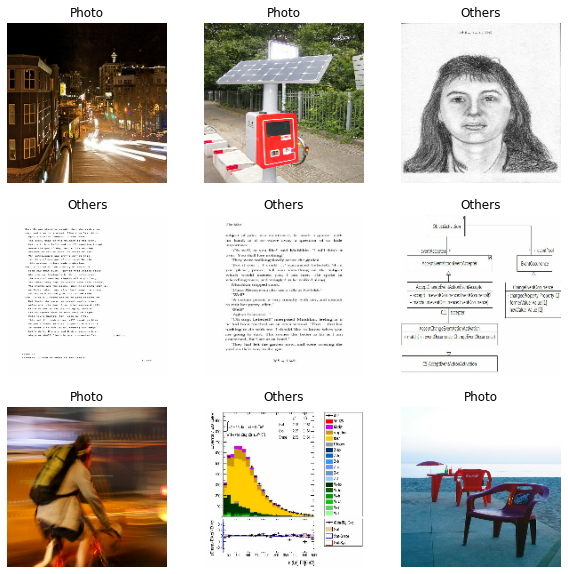

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # convert to int
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

Nous allons former un modèle à l'aide de ces ensembles de données en les passant à `Model.fit` dans un instant. Si nous le souhaitons, nous pouvons également itérer manuellement sur le jeu de données et récupérer des lots d'images :

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 1)


Le lot d'images est un tenseur de la forme (32, 180, 180, 3). Il s'agit d'un lot de 32 images de forme 180x180x3 (la dernière dimension fait référence aux canaux de couleur RGB). Le lot `label_batch` est un tenseur de la forme (32,), ce sont les étiquettes correspondantes aux 32 images.

On peut appeler `.numpy()` sur les tenseurs `image_batch` et `labels_batch` pour les convertir en un `numpy.ndarray`.

## **Configurer l'ensemble de données pour la performance**

---



Veillons à utiliser la préextraction en mémoire tampon afin de pouvoir céder des données depuis le disque sans que les E/S ne deviennent bloquantes. Ce sont deux méthodes importantes que nous devrons utiliser lors du chargement des données :

- `Dataset.cache` garde les images en mémoire après qu'elles aient été chargées depuis le disque pendant la première époque. Cela permet de s'assurer que le jeu de données ne devient pas un goulot d'étranglement lors de l'entraînement de votre modèle. Si votre jeu de données est trop grand pour tenir en mémoire, on peut également utiliser cette méthode pour créer un cache performant sur le disque.
- `Dataset.prefetch` chevauche le prétraitement des données et l'exécution du modèle pendant l'entraînement.

Les lecteurs intéressés peuvent en savoir plus sur ces deux méthodes, ainsi que sur la façon de mettre les données en cache sur le disque dans la section *Prefetching* du guide [Better performance with the tf.data API](../../guide/data_performance.ipynb).


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Créer le modéle**

---



Le modèle [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) consiste en trois blocs de convolution (`tf.keras.layers.Conv2D`) avec une couche de pooling max (`tf.keras.layers.MaxPooling2D`) dans chacun d'eux. Il y a une couche entièrement connectée (`tf.keras.layers.Dense`) avec 128 unités au sommet qui est activée par une fonction d'activation ReLU (`'relu'`).

In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # a single neuron output layer which gives 1 for Photo and 0 for Others 
  # we use sigmoid activation function to get a binary output that lie between 0 and 1
  layers.Dense(1, activation='sigmoid')
])

## **Compiler le model**

---



Maintenant, nous choisissons l'optimiseur `tf.keras.optimizers.Adam` et la fonction de perte `tf.keras.losses.SparseCategoricalCrossentropy` pour la compilation du modèle. Pour afficher la précision de l'apprentissage et de la validation pour chaque époque d'apprentissage, nous passons l'argument `metrics` à `Model.compile`.
Les métriques définissent les paramètres des données que nous allons utiliser pour mesurer les performances.
Model.compile aide à compiler un modèle de keras.


In [16]:
model.compile(optimizer='adam',
              #Binary_crossentropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. 
              #It then calculates the score that penalizes the probabilities based on the distance from the expected value. 
              #That means how close or far from the actual value
              loss='binary_crossentropy',
              metrics=['accuracy'])

## **Résumé du modèle et Shéma**

---



Affichons maintenant toutes les couches du réseau en utilisant la méthode `Model.summary` du modèle :

In [17]:
model.summary()

#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## **Entraîner le modèle**

---



In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1036/1036 [==============================] - 297s 243ms/step - loss: 0.3176 - accuracy: 0.8427 - val_loss: 0.2555 - val_accuracy: 0.8852
Epoch 2/10
1036/1036 [==============================] - 230s 222ms/step - loss: 0.2253 - accuracy: 0.9025 - val_loss: 0.2427 - val_accuracy: 0.8981
Epoch 3/10
1036/1036 [==============================] - 229s 221ms/step - loss: 0.1784 - accuracy: 0.9263 - val_loss: 0.1825 - val_accuracy: 0.9205
Epoch 4/10
1036/1036 [==============================] - 230s 222ms/step - loss: 0.1356 - accuracy: 0.9455 - val_loss: 0.2040 - val_accuracy: 0.9161
Epoch 5/10
1036/1036 [==============================] - 229s 222ms/step - loss: 0.0937 - accuracy: 0.9650 - val_loss: 0.2169 - val_accuracy: 0.9256
Epoch 6/10
1036/1036 [==============================] - 229s 221ms/step - loss: 0.0623 - accuracy: 0.9772 - val_loss: 0.2434 - val_accuracy: 0.9162
Epoch 7/10
1036/1036 [==============================] - 229s 221ms/step - loss: 0.0415 - accuracy: 0.9852 - val_

## **Visualiser les résultats de l'apprentisage**

---



Nous allons créer des graphiques de perte et de précision sur les ensembles de formation et de validation :

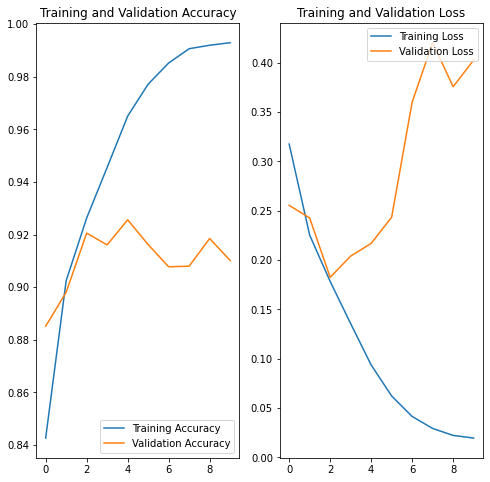

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Les graphiques montrent que la précision de la formation et celle de la validation sont très éloignées l'une de l'autre, vérifions ce qui n'a pas fonctionné et essayons d'améliorer la performance globale du modèle.

## **Overfitting**

---



Dans les graphiques ci-dessus, la précision de la formation augmente linéairement au fil du temps. De plus, la différence de précision entre la précision de formation et la précision de validation est notable - un signe d'overfitting

Lorsqu'il y a un petit nombre d'exemples de formation, le modèle apprend parfois des bruits ou des détails indésirables des exemples de formation, à tel point que cela a un impact négatif sur les performances du modèle sur les nouveaux exemples. Ce phénomène est connu sous le nom d'overfitting. Il signifie que le modèle aura du mal à se généraliser sur un nouvel ensemble de données.

## **Data augmentation**

---



L'augmentation des données se produit généralement lorsque le nombre d'exemples d'apprentissage est faible. [L'augmentation des données](./data_augmentation.ipynb) consiste à générer des données d'apprentissage supplémentaires à partir des exemples existants en les augmentant à l'aide de transformations aléatoires qui produisent des images d'apparence crédible. Cela permet d'exposer le modèle à davantage d'aspects des données et de mieux les généraliser.

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## **Dropout**

---



Une autre technique permettant de réduire l'overfitting consiste à introduire une régularisation [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) dans le réseau.

Créons un nouveau réseau neuronal avec `tf.keras.layers.Dropout` avant de l'entraîner en utilisant les images augmentées :

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # a single neuron output layer which gives 1 for Photo and 0 for Others 
  # we use sigmoid activation function to get a binary output that lie between 0 and 1
  layers.Dense(1, activation='sigmoid')
])

## **Compiler et entrainer le modèle**

---



In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
1036/1036 [==============================] - 283s 272ms/step - loss: 0.3445 - accuracy: 0.8220 - val_loss: 0.2853 - val_accuracy: 0.8625
Epoch 2/15
1036/1036 [==============================] - 268s 259ms/step - loss: 0.2823 - accuracy: 0.8674 - val_loss: 0.2476 - val_accuracy: 0.8853
Epoch 3/15
1036/1036 [==============================] - 266s 257ms/step - loss: 0.2515 - accuracy: 0.8865 - val_loss: 0.2486 - val_accuracy: 0.8877
Epoch 4/15
1036/1036 [==============================] - 266s 256ms/step - loss: 0.2308 - accuracy: 0.9007 - val_loss: 0.2094 - val_accuracy: 0.9115
Epoch 5/15
1036/1036 [==============================] - 268s 259ms/step - loss: 0.2149 - accuracy: 0.9074 - val_loss: 0.2364 - val_accuracy: 0.8953
Epoch 6/15
1036/1036 [==============================] - 269s 260ms/step - loss: 0.2035 - accuracy: 0.9134 - val_loss: 0.2286 - val_accuracy: 0.9097
Epoch 7/15
1036/1036 [==============================] - 269s 260ms/step - loss: 0.1919 - accuracy: 0.9197 - val_

#### **Sauvegarder notre modèle**


In [25]:
model.save("binary_classification_modal.h5")

#### **Télécharger notre modèle**


In [25]:
model = keras.models.load_model("binary_classification_modal.h5")

## **Visualiser les résultats de l'apprentissage**

---



Après avoir appliqué l'augmentation des données et `tf.keras.layers.Dropout`, il y a moins de sur-apprentissage qu'avant, et la précision de l'entraînement et de la validation sont plus proches :

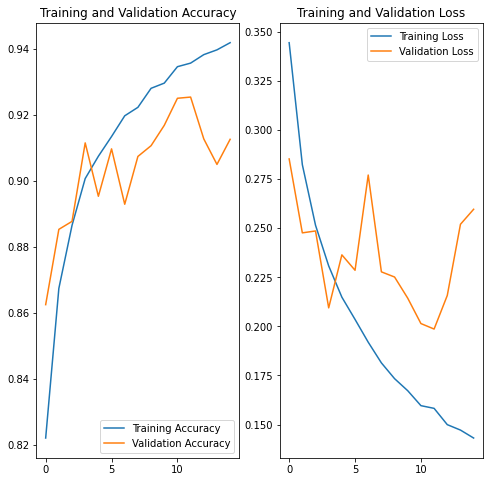

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Prédire sur de nouvelles données**

---



Enfin, utilisons notre modèle pour classer une image qui n'était pas incluse dans les ensembles de formation ou de validation.

Note : Les couches d'augmentation et de suppression des données sont inactives au moment de l'inférence.

In [27]:
# Random Photo Image url
PhotoURL = "https://www.cnet.com/a/img/-qQkzFVyOPEoBRS7K5kKS0GFDvk=/940x0/2020/04/16/7d6d8ed2-e10c-4f91-b2dd-74fae951c6d8/bazaart-edit-app.jpg"

# Random Painting Image url
PaintingURL = "https://www.1st-art-gallery.com/thumbnail/45000/45789/painting_page_800x/Van-Gogh/Starry-Night.jpg?ts=1607374778"

# Random Schematic Image url
SchematicURL = "https://s3.ap-south-1.amazonaws.com/afteracademy-server-uploads/what-is-schema-diagram-b8915aa44db73ede.jpg"

# Random Sketch Image url
SketchURL = "https://i.pinimg.com/474x/03/7c/cf/037ccfd7f82827ae8c4cae86c7f3fb99.jpg"

# Random Text Image url
TextURL = "https://media.cheggcdn.com/study/b08/b08161c4-5061-4b8d-9be8-6435541a5fc2/image"

In [63]:
def isPhoto(url):
    # Display photo
    image = imread(url)
    plt.imshow(image)
    plt.show()
    
    # REPLACE ORIGIN PARAM
    image = tf.keras.utils.get_file(origin=url)
    img = tf.keras.utils.load_img(image, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    predictons = round(predictions[0][0])
    # Binary Classification
    print(predictons)
    print (round(predictions[0][0]) == 1 and "This image is a Photo" or "This image is not a Photo")

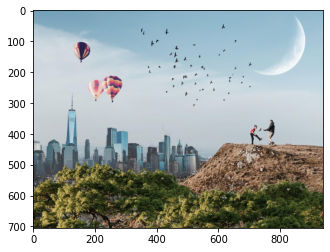

1
This image is a Photo


In [65]:
isPhoto(PhotoURL)

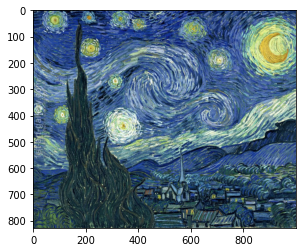

0
This image is not a Photo


In [66]:
isPhoto(PaintingURL)

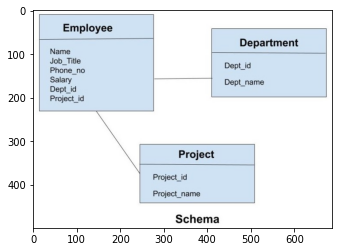

0
This image is not a Photo


In [67]:
isPhoto(SchematicURL)

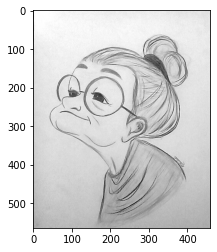

0
This image is not a Photo


In [68]:
isPhoto(SketchURL)

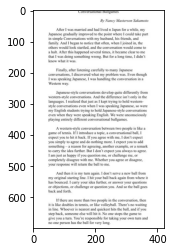

0
This image is not a Photo


In [70]:
isPhoto(TextURL)

# **Conclusion**

Nous remarquons que la précision durant les prédictions sur de nouvelles données est assez gratifiante avec 99% environ sur la plupart des prédictions. Notre modèle réussit donc bien sa mission qui était de différencier les photos du reste des données du jeu de données.